<a href="https://colab.research.google.com/github/DarekGit/Documents/blob/master/05_03_01_FDDB_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Porównanie modeli

Instalacja Detectron2, pobranie datasetu i narzędzi

In [1]:
# install detectron2:

!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

  Using cached https://files.pythonhosted.org/packages/9f/2c/9417b5c774792634834e730932745bc09a7d36754ca00acf1ccd1ac2594d/PyYAML-5.1.tar.gz
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=d8f153347d3a7ff7ac131a4938c1b121dfa9f9603ffa949572858fe977806fc8
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-opnbg953
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-opnbg953
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266459 sha256=a75c251c5ed01e3945c2b2c5c90f283d51e3223e894748e6afe15b8180e58ff9
  Stored in directory: /tmp/pip-ephem-wheel-cache-7n4525zg/wheels/90/51/41/646daf401c3bc408ff10d

In [2]:
!wget http://tamaraberg.com/faceDataset/originalPics.tar.gz
!wget vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
!mkdir FDDB
!tar -C FDDB -zxf originalPics.tar.gz > /dev/null
!tar -C FDDB -zxf FDDB-folds.tgz > /dev/null

--2020-07-30 13:27:39--  http://tamaraberg.com/faceDataset/originalPics.tar.gz
Resolving tamaraberg.com (tamaraberg.com)... 54.221.205.183
Connecting to tamaraberg.com (tamaraberg.com)|54.221.205.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579061091 (552M) [application/x-gzip]
Saving to: ‘originalPics.tar.gz’

originalPics.tar.gz 100%[===================>] 552.24M  8.63MB/s    in 46s     

2020-07-30 13:28:25 (11.9 MB/s) - ‘originalPics.tar.gz’ saved [579061091/579061091]

--2020-07-30 13:28:26--  http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160724 (157K) [application/x-gzip]
Saving to: ‘FDDB-folds.tgz’

FDDB-folds.tgz      100%[===================>] 156.96K   404KB/s    in 0.4s    

2020-07-30 13:28:27 (404 KB/s) - ‘FDDB-folds.tgz’ sav

In [22]:
# mobilenet
!gdown https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
!unzip -qo mobilenet.zip
!rm -f mobilenet.zip

# Download tools

!gdown https://drive.google.com/uc?id=1_9ydMZlTNFXBOMl16xsU8FSBmK2PW4lN -O FDDB/tools.py
!wget -q -O FDDB/mAP.py https://drive.google.com/uc?id=1PtEsobTFah3eiCDbSsYblOGbe2fmkjGR

Downloading...
From: https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
To: /content/mobilenet.zip
100% 11.8k/11.8k [00:00<00:00, 18.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_9ydMZlTNFXBOMl16xsU8FSBmK2PW4lN
To: /content/FDDB/tools.py
100% 4.47k/4.47k [00:00<00:00, 7.72MB/s]


<font color=yellow> Restart runtime to continue... <b>Crtl+M.</b> </font>

In [1]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Thu Jul 30 13:32:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
import time
from tqdm.notebook import tqdm
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import gdown
from google.colab import drive
import os
import cv2
import random
import itertools
import shutil
import glob
import json
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import collections as mc

from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
import detectron2.utils.comm as comm
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from mobilenet.utils import  add_mobilenet_config, build_mobilenetv2_fpn_backbone
from FDDB.mAP import mAP, plot_mAP
from FDDB.tools import annotations,output_Files

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [24]:
IMAGES_PATH='FDDB/'

In [25]:
def fddb_rectangular_annotation(IMAGES_PATH=IMAGES_PATH):
  ''' zwraca listę boxy obliczone na podstawie *ellipseList.txt
      i względną ścieżkę do pliku
      
      [{'boxes': array([[184.1439,  38.1979, 355.2429, 285.3645]]),
        'path': '2002/08/11/big/img_591'}]
  '''
  fddb_annotations =  []
  ellipseList = glob.glob(IMAGES_PATH+"FDDB-folds/*ellipseList.txt")
  ellipseList.sort()

  for item in ellipseList:
    with open(item, "r") as file_:
      rows = file_.readlines()
    
    idx = 0
    while (idx < len(rows)):
      tmp = []
      image_name = rows[idx].replace("\n", "")
      number_of_faces = int(rows[idx+1])
      boxes = []

      for i in range(1, number_of_faces+1):
        box = rows[idx+1+i]
        box = [float(item) for item in box.split(' ')[0:5]]
        xmin = float(box[3]- box[1])
        ymin = float(box[4]- box[0])
        xmax = float(xmin + box[1]*2)
        ymax = float(ymin + box[0]*2)
        boxes.append([xmin, ymin, xmax, ymax])
      
      boxes=np.array(boxes)
      fddb_annotations.append({'path':image_name,'boxes':boxes})
      idx += (number_of_faces+2)

  return fddb_annotations

In [26]:
fddb_annotations = fddb_rectangular_annotation(IMAGES_PATH)

In [27]:
fddb_annotations[0]

{'boxes': array([[184.1439,  38.1979, 355.2429, 285.3645]]),
 'path': '2002/08/11/big/img_591'}

In [7]:
def get_fddb_dict(annotations):
  '''Przerabia annotacje z fddb_rectangular_annotation()
  na słownik wymagany przez detectron2.data.DatasetCatalog

  {'annotations': [{'bbox': [59, 71, 269, 353],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0,
   'iscrowd': 0,
   'segmentation': [[59, 71, 269, 71, 269, 353, 59, 353]]}],
   'file_name': 'FDDB/2002/07/29/big/img_136.jpg',
   'height': 450,
  'image_id': 18,
  'width': 319}

  '''
  dataset_dicts = []
  for idx, item in enumerate(annotations):
    record = {}
    file_path = IMAGES_PATH+item["path"]+".jpg"

    record["file_name"] = file_path 
    record["image_id"] = idx
    record["height"], record["width"] = cv2.imread(file_path).shape[:2]

    objs = []
    for box in item["boxes"]:
      box = [int(i) for i in box] # int vs float..
      xmin, ymin, xmax, ymax = box
      poly = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": 0,
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)

  return dataset_dicts

Rejestracja datasetu 

In [11]:
classes = ['face']
for d in ["val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: get_fddb_dict(fddb_annotations if d == "val" else "null"))
  MetadataCatalog.get("faces_" + d).set(thing_classes = classes)

faces_metadata = MetadataCatalog.get("faces_val")

In [12]:
faces_metadata

Metadata(name='faces_val', thing_classes=['face'])

Wizualizacja annotacji na plikach z val

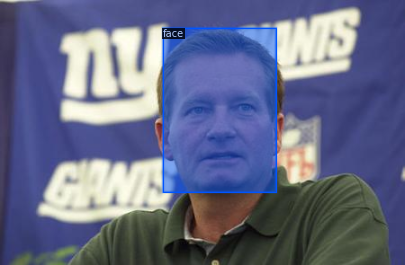

In [13]:
dataset_dicts = get_fddb_dict(fddb_annotations)
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=faces_metadata, scale=0.9)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Modele do testu 

In [28]:
models = {
    # '800k' - parametry domyślne - jako punkt odniesienia
    '800k': {
        'config': 'FrozenBN',
        'pth': 'https://drive.google.com/uc?id=1-tqNKwZIFmkAbfJ1L2sibIO4PT_MwnVA',
        'weights_name': 'model_0799999.pth'},

    # 'BN_800k' - dodano BN - pokazanie wpływu BN przy małym batchu=2
    'BN_800k': {
        'config': 'BN',
        'pth': 'https://drive.google.com/uc?id=1-kRDjqkMk9qXbNfzVx09VE35YzgkP1AO',
        'weights_name': 'model_0799999.pth'},

    #'BN_Mish_V2_250+F_2_50k' - najlepszy wynik uczenie z Mish BN 250k + 50k z FrozenBN
    'BN_Mish_V2_250+F_2_50k': {
        'config': 'BN_Mish_V2F',
        'pth': 'https://drive.google.com/uc?id=1-I6YSAs9NrORI4cFISfK_-4Yhm1twfDi',
        'weights_name': 'model_0049999.pth'},
    
    # 'BN_Mish_V3_80+30k' - najszybsze uczenie 110k iteracji
    'BN_Mish_V3_80+_30k': {
        'config': 'BN_Mish_V3',
        'pth': 'https://drive.google.com/uc?id=1--bP5VPyqIrfrBxVZ5eLSsupIvBlQ8ef',
        'weights_name': 'model_0029999.pth'},

    # 'R50_C4_270k' - Detectron2 z backbone na R50 C4
    'R50_C4_270k': {
        'config': 'R50_C4',
        'pth': 'https://drive.google.com/uc?id=1-I4m091opkwIRHhvMLftt0eAQp6G0CmJ',
        'weights_name': 'model_0269999.pth'}
    }

Zestawy z konfiguracja podstawowych (cfg)


In [29]:
cfg_set = {
    'FrozenBN':'https://drive.google.com/uc?id=1rZFzJaR_g7uYuTguTdbUuCQYD4eXLeqw',
    'BN': 'https://drive.google.com/uc?id=1-doXtwe5iZHoqPzKGc2ZZbxj6Ebhxsn4',
    'BN_V2':'https://drive.google.com/uc?id=1wywB8UAaOO5KZx3IS35kV-rLsvJMIse6',
    'BN_Mish':'https://drive.google.com/uc?id=1-axV3KKg8-YiZZ7uDBh_2v181JoC9Nj3',
    'BN_Mish_V2':'https://drive.google.com/uc?id=1WoESx5RYvpapNicpSrmMoNJeE2GVm3zK',
    'BN_Mish_V3':'https://drive.google.com/uc?id=1-Kgd_2AS4EsD_ZPqP7SxkscyDjP-Qhnr',
    'BN_Mish_V2F':'https://drive.google.com/uc?id=1pCwyYCjIoduro2vIKMZi5HhlpaypH0_x',
    'R50_C4':'https://drive.google.com/uc?id=1-5P5Xyx5GM26p7g89CY-SSX0aluB7H9U',}

In [30]:
def cfg_write(cfg,cfg_all):
  for key in cfg_all.keys():
    if isinstance(cfg_all[key],dict): 
      cfg_write(cfg[key],cfg_all[key])
    else: cfg[key]=cfg_all[key]
  return cfg

def set_predictor(model_name=None, models_dict=models, cfg_dict=cfg_set ,device='cuda', cfg_DATASETS_TEST=None):
  url = models_dict[model_name]['pth'] 
  out = models_dict[model_name]['weights_name']
  gdown.download(url, out, True)
  # model configuration
  url_cfg = cfg_dict[models_dict[model_name]['config']] 
  gdown.download(url_cfg, "temporary.json", True)
  with open('temporary.json','r') as f:
    cfg_all=json.load(f)
  cfg = get_cfg()
  add_mobilenet_config(cfg)
  cfg = cfg_write(cfg,cfg_all)
  cfg.MODEL.WEIGHTS = models_dict[model_name]['weights_name']
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
  cfg.MODEL.DEVICE=device
  if cfg_DATASETS_TEST is not None:
    cfg.DATASETS.TEST = (cfg_DATASETS_TEST, )

  return DefaultPredictor(cfg), cfg

Funkcja pomiaru czasu ewaluacji modelu

In [31]:
def time_measurement(predictor, dataset):
  time_ = []
  for item in tqdm(dataset):
    start_ = time.time()
    img = cv2.imread(item["file_name"])
    outputs = predictor(img)
    diff = time.time() - start_
    time_.append(diff)
  # Total time
  total_time = np.array(time_).sum()
  # Mean time
  mean_diff = np.array(time_).mean()
  # Frames per second 
  fps = 1 / mean_diff
  print("Total time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))
  return {"total_time": total_time, "mean_diff": mean_diff, "fps": fps}

Funkcja do ewaluacji modelu na FDDB

In [18]:
def predict_on_val(dataset, predictor, model_name):
    gbxs=[]
    dbxs=[]
    dset=dataset
    if 'annotations' in dataset[0].keys():  
      dset=[]
      for r in dataset:
        dset.append({'path' : r['file_name'],'marks' : [b['bbox'] for b in r['annotations']],
                     'persons': ['' for b in r['annotations']]})

    for item in tqdm(dset):
        im = cv2.imread(item["path"])
        outputs = predictor(im)
        pbxs = outputs['instances'].pred_boxes.tensor.tolist()
        pconfs = outputs['instances'].scores.tolist()
        dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
        dbxs.append(dbx)
        gbxs.append(item['marks'])
    
    return {'gbxs':gbxs,'dbxs':dbxs,'metric':dset} 

In [39]:
def dict_to_file(dic, path):
    f = open(path,'w')
    f.write(str(dic))
    f.close()

def dict_from_file(filename):
    f = open(filename,'r')
    data=f.read()
    f.close()
    return eval(data)

Pomiar czasu ewaluacji modeli na zbiorze walidacyjnym


In [34]:
dataset = get_fddb_dict(fddb_annotations)

In [35]:
time_measurement_results = {}
for model in models:
  print(model)
  predictor, _ = set_predictor(model)
  time_measurement_results[model] = time_measurement(predictor, dataset=dataset)

print(time_measurement_results)

800k



Total time(sec): 172.24, Average(sec):0.06, fps:16.52

BN_800k



Total time(sec): 171.96, Average(sec):0.06, fps:16.55

BN_Mish_V2_250+F_2_50k



Total time(sec): 194.33, Average(sec):0.07, fps:14.64

BN_Mish_V3_80+_30k



Total time(sec): 193.51, Average(sec):0.07, fps:14.70

R50_C4_270k
WARNING [07/30 14:03:05 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.



Total time(sec): 693.68, Average(sec):0.24, fps:4.10

{'800k': {'total_time': 172.2449450492859, 'mean_diff': 0.06054303868164706, 'fps': 16.517175579149427}, 'BN_800k': {'total_time': 171.95506262779236, 'mean_diff': 0.060441146793600124, 'fps': 16.545020289156493}, 'BN_Mish_V2_250+F_2_50k': {'total_time': 194.32584047317505, 'mean_diff': 0.06830433760041302, 'fps': 14.640358652624622}, 'BN_Mish_V3_80+_30k': {'total_time': 193.51394033432007, 'mean_diff': 0.06801895969571883, 'fps': 14.701783215642752}, 'R50_C4_270k': {'total_time': 693.6814067363739, 'mean_diff': 0.24382474753475356, 'fps': 4.1013064100782675}}


In [36]:
time_measurement_results

{'800k': {'fps': 16.517175579149427,
  'mean_diff': 0.06054303868164706,
  'total_time': 172.2449450492859},
 'BN_800k': {'fps': 16.545020289156493,
  'mean_diff': 0.060441146793600124,
  'total_time': 171.95506262779236},
 'BN_Mish_V2_250+F_2_50k': {'fps': 14.640358652624622,
  'mean_diff': 0.06830433760041302,
  'total_time': 194.32584047317505},
 'BN_Mish_V3_80+_30k': {'fps': 14.701783215642752,
  'mean_diff': 0.06801895969571883,
  'total_time': 193.51394033432007},
 'R50_C4_270k': {'fps': 4.1013064100782675,
  'mean_diff': 0.24382474753475356,
  'total_time': 693.6814067363739}}

Porównanie wyników 

In [37]:
df_time_measurement_results = pd.DataFrame.from_dict(time_measurement_results, orient='index')
df_time_measurement_results

,total_time,mean_diff,fps
800k,172.244945,0.060543,16.517176
BN_800k,171.955063,0.060441,16.545020
BN_Mish_V2_250+F_2_50k,194.325840,0.068304,14.640359
BN_Mish_V3_80+_30k,193.513940,0.068019,14.701783
R50_C4_270k,693.681407,0.243825,4.101306


Ewaluacja modeli na zbiorze walidacyjnym i mAP liczone funkcją Darka

In [38]:
FDDB_DATASET = get_fddb_dict(fddb_annotations)

In [40]:
pred = {}
for model in models:
  print(model)
  predictor, cfg = set_predictor(model)
  pred[model] = predict_on_val(FDDB_DATASET ,predictor, model)

800k



BN_800k



BN_Mish_V2_250+F_2_50k



BN_Mish_V3_80+_30k



R50_C4_270k
WARNING [07/30 14:29:25 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


In [41]:
drive.mount('/content/drive')
OUTPUT_DIR_NAME = "OUTPUT_DIR_FDDB"
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)

print(OUTPUT_DIR_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
./drive/My Drive/OUTPUT_DIR_FDDB


In [42]:
output_file_name = "FDDB_output_dict"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(pred, output_file)

In [43]:
output_file_name = "time_measurement_results_dict"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(time_measurement_results, output_file)

mAP dla testowanych modeli 

In [44]:
def model_mAP(pdict, model_name, title="Detectron2_Wider_Face_mAP_"):
  m,d=mAP(gbxs=pdict[model_name]['gbxs'],dbxs=pdict[model_name]['dbxs'],data=True)
  # plot_mAP(m,d,['All 0.50','All 0.00','large','medium','small'],1,title+model_name+'  conf>0',file=title+model_name)
  plot_mAP(m,d,'All',1,title+model_name+'  conf>0',file=title+model_name)
  return m,d

In [45]:
all_models_mAP = {}
pred.keys()

dict_keys(['800k', 'BN_800k', 'BN_Mish_V2_250+F_2_50k', 'BN_Mish_V3_80+_30k', 'R50_C4_270k'])

Model: 800k
All 0.50:   AP: 56.75%   Recall: 65.56%   IoU: 0.50
All 0.55:   AP: 50.87%   Recall: 60.24%   IoU: 0.55
All 0.60:   AP: 40.74%   Recall: 51.94%   IoU: 0.60
All 0.65:   AP: 26.71%   Recall: 40.84%   IoU: 0.65
All 0.70:   AP: 12.05%   Recall: 27.17%   IoU: 0.70
All 0.75:   AP:  3.19%   Recall: 13.96%   IoU: 0.75
All 0.80:   AP:  0.38%   Recall:  5.09%   IoU: 0.80
All 0.85:   AP:  0.03%   Recall:  1.26%   IoU: 0.85
All 0.90:   AP:  0.00%   Recall:  0.25%   IoU: 0.90
All 0.95:   AP:  0.00%   Recall:  0.02%   IoU: 0.95
All 0.00:   AP: 70.33%   Recall: 81.96%   IoU: 0.00
small   :   AP: 45.39%   Recall: 73.95%   IoU: 0.50
medium  :   AP: 71.20%   Recall: 76.97%   IoU: 0.50
large   :   AP: 51.71%   Recall: 57.19%   IoU: 0.50


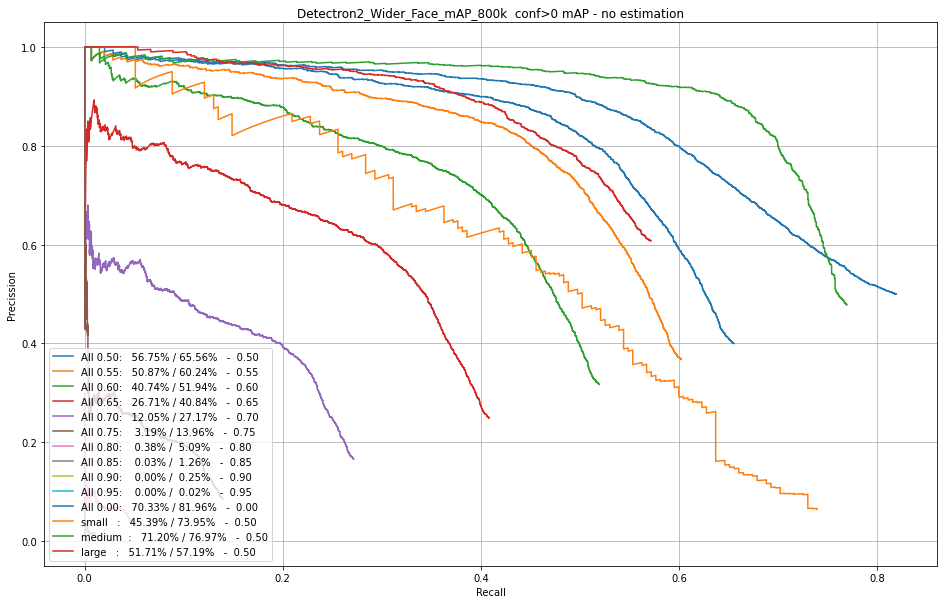

In [46]:
modelshow = list(pred.keys())[0]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: BN_800k
All 0.50:   AP: 89.78%   Recall: 90.47%   IoU: 0.50
All 0.55:   AP: 87.63%   Recall: 88.53%   IoU: 0.55
All 0.60:   AP: 82.71%   Recall: 84.45%   IoU: 0.60
All 0.65:   AP: 71.61%   Recall: 76.72%   IoU: 0.65
All 0.70:   AP: 48.56%   Recall: 61.42%   IoU: 0.70
All 0.75:   AP: 19.35%   Recall: 38.95%   IoU: 0.75
All 0.80:   AP:  3.42%   Recall: 17.02%   IoU: 0.80
All 0.85:   AP:  0.32%   Recall:  5.30%   IoU: 0.85
All 0.90:   AP:  0.01%   Recall:  0.72%   IoU: 0.90
All 0.95:   AP:  0.00%   Recall:  0.06%   IoU: 0.95
All 0.00:   AP: 93.68%   Recall: 94.39%   IoU: 0.00
small   :   AP: 59.64%   Recall: 73.95%   IoU: 0.50
medium  :   AP: 82.23%   Recall: 83.35%   IoU: 0.50
large   :   AP: 96.36%   Recall: 96.51%   IoU: 0.50


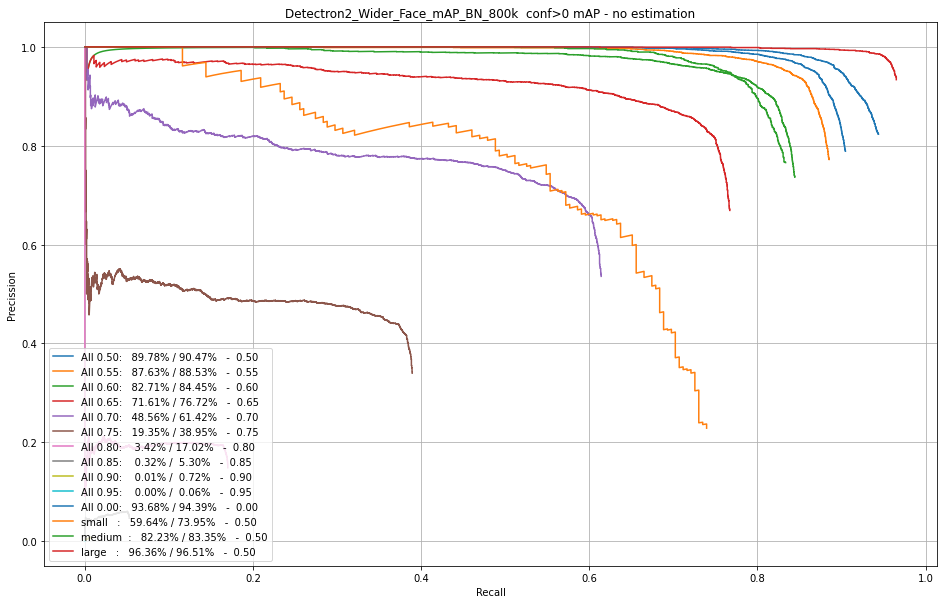

In [47]:
modelshow = list(pred.keys())[1]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: BN_Mish_V2_250+F_2_50k
All 0.50:   AP: 91.69%   Recall: 92.36%   IoU: 0.50
All 0.55:   AP: 88.78%   Recall: 89.83%   IoU: 0.55
All 0.60:   AP: 82.76%   Recall: 85.03%   IoU: 0.60
All 0.65:   AP: 67.78%   Recall: 74.82%   IoU: 0.65
All 0.70:   AP: 39.59%   Recall: 55.56%   IoU: 0.70
All 0.75:   AP: 11.11%   Recall: 29.57%   IoU: 0.75
All 0.80:   AP:  1.13%   Recall:  9.67%   IoU: 0.80
All 0.85:   AP:  0.04%   Recall:  1.82%   IoU: 0.85
All 0.90:   AP:  0.00%   Recall:  0.21%   IoU: 0.90
All 0.95:   AP:  0.00%   Recall:  0.02%   IoU: 0.95
All 0.00:   AP: 94.99%   Recall: 95.57%   IoU: 0.00
small   :   AP: 64.55%   Recall: 82.33%   IoU: 0.50
medium  :   AP: 85.37%   Recall: 86.54%   IoU: 0.50
large   :   AP: 96.92%   Recall: 97.05%   IoU: 0.50


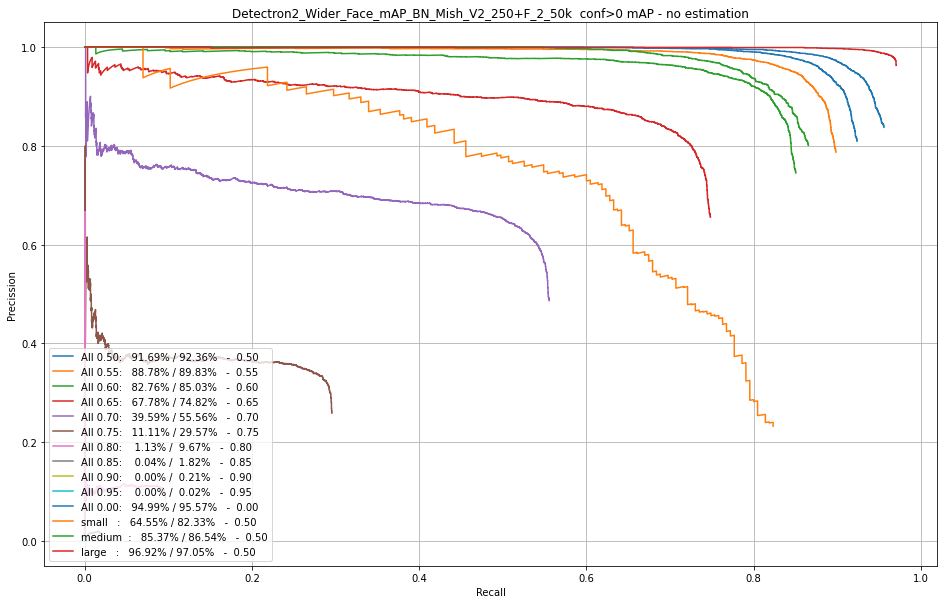

In [48]:
modelshow = list(pred.keys())[2]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: BN_Mish_V3_80+_30k
All 0.50:   AP: 91.09%   Recall: 91.72%   IoU: 0.50
All 0.55:   AP: 88.77%   Recall: 89.71%   IoU: 0.55
All 0.60:   AP: 83.01%   Recall: 85.26%   IoU: 0.60
All 0.65:   AP: 71.76%   Recall: 77.55%   IoU: 0.65
All 0.70:   AP: 47.77%   Recall: 61.79%   IoU: 0.70
All 0.75:   AP: 17.05%   Recall: 37.11%   IoU: 0.75
All 0.80:   AP:  2.53%   Recall: 14.72%   IoU: 0.80
All 0.85:   AP:  0.12%   Recall:  3.31%   IoU: 0.85
All 0.90:   AP:  0.00%   Recall:  0.41%   IoU: 0.90
All 0.95:   AP:  0.00%   Recall:  0.00%   IoU: 0.95
All 0.00:   AP: 94.12%   Recall: 94.68%   IoU: 0.00
small   :   AP: 60.59%   Recall: 77.67%   IoU: 0.50
medium  :   AP: 84.32%   Recall: 85.19%   IoU: 0.50
large   :   AP: 97.04%   Recall: 97.19%   IoU: 0.50


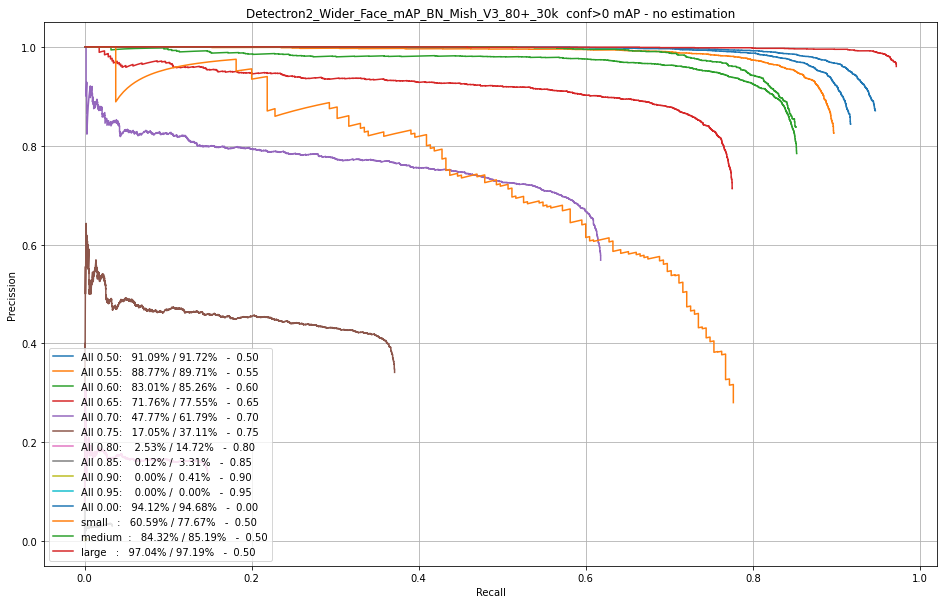

In [49]:
modelshow = list(pred.keys())[3]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: R50_C4_270k
All 0.50:   AP: 93.20%   Recall: 93.73%   IoU: 0.50
All 0.55:   AP: 90.49%   Recall: 91.28%   IoU: 0.55
All 0.60:   AP: 84.42%   Recall: 86.42%   IoU: 0.60
All 0.65:   AP: 69.11%   Recall: 75.83%   IoU: 0.65
All 0.70:   AP: 38.22%   Recall: 54.90%   IoU: 0.70
All 0.75:   AP: 11.67%   Recall: 29.78%   IoU: 0.75
All 0.80:   AP:  1.19%   Recall:  9.26%   IoU: 0.80
All 0.85:   AP:  0.03%   Recall:  1.22%   IoU: 0.85
All 0.90:   AP:  0.00%   Recall:  0.06%   IoU: 0.90
All 0.95:   AP:  0.00%   Recall:  0.00%   IoU: 0.95
All 0.00:   AP: 96.63%   Recall: 97.02%   IoU: 0.00
small   :   AP: 65.22%   Recall: 81.40%   IoU: 0.50
medium  :   AP: 87.91%   Recall: 88.98%   IoU: 0.50
large   :   AP: 97.76%   Recall: 97.86%   IoU: 0.50


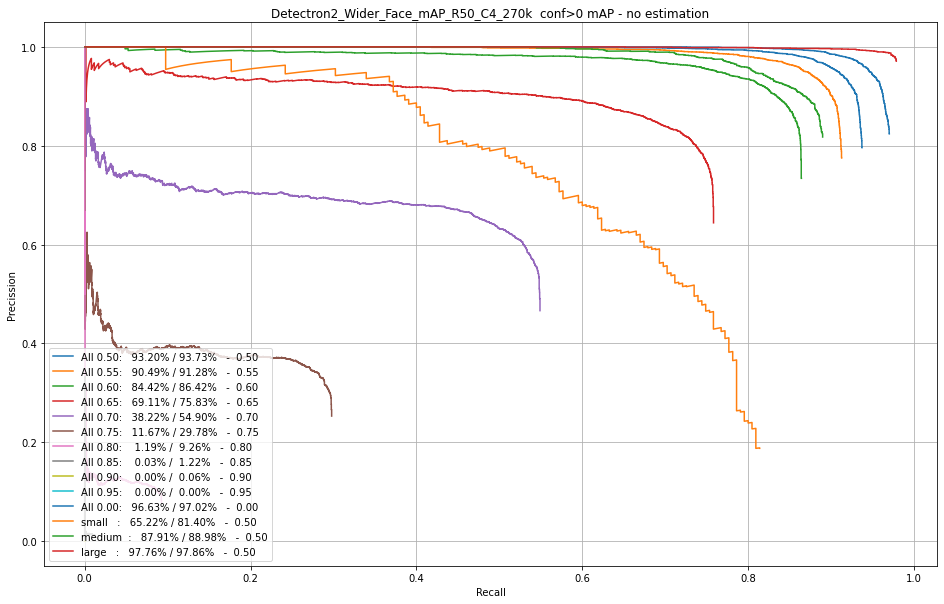

In [50]:
modelshow = list(pred.keys())[4]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Zapis wyników 

In [51]:
output_file_name = "all_models_mAP"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(all_models_mAP, output_file)

In [53]:
modeldict = {}
DD_mAP = {}
for item in all_models_mAP.keys():
  for i in all_models_mAP[item][0].keys():
    modeldict[i] =  {
        "AP" : all_models_mAP[item][0][i][0]*100,
        "Recall" : all_models_mAP[item][0][i][1]*100,
        "IoU" : all_models_mAP[item][0][i][2]*100,
    }
  DD_mAP[item] = modeldict 

In [54]:
output_file_name = "all_models_mAP_t"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(DD_mAP, output_file)

Ewaluacja na FDDB z wykorzystaniem COCOEvaluator i funkc

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
AP_VAL = {}
drive.mount('/content/drive')
OUTPUT_DIR_NAME = "OUTPUT_DIR_FDDB"
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)

for model in models:
  print(model)
  destination = os.path.join(OUTPUT_DIR_PATH, model)
  if not os.path.exists(destination):
    os.makedirs(destination)
  predictor, cfg = set_predictor(model, cfg_DATASETS_TEST="faces_val")
  print(cfg.DATASETS.TEST)
  print(destination)

  evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=destination)
  val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
  inference_on_dataset(predictor.model, val_loader, evaluator)
  AP_VAL[model] = evaluator.evaluate()

In [ ]:
output_file_name = "AP_COCOEvaluator"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(AP_VAL, output_file)

Porównanie wyników

In [ ]:
AP_FDDB = {}
for item in AP_VAL.keys():
  AP_FDDB[item] = AP_VAL[item]['bbox']

df_AP_FDDB = pd.DataFrame.from_dict(AP_FDDB, orient='index')